<a href="https://colab.research.google.com/github/japanipsystem/Test/blob/master/0625_mhawkes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
class UniRnd(object):
    def __init__(self, sz=100):
        self.sz = sz
        self.us = np.zeros(self.sz)
        self.pos = sz

    def get(self):
        if self.pos >= self.sz:
            self.us = np.random.uniform(0, 1, self.sz)
            self.pos = 0
        u = self.us[self.pos]
        self.pos += 1
        return(u)


class Zetad(object): # (5.4)
    def __init__(self, s, ceil, sz=100):
        self.s = s # parameter
        self.ceil = ceil # ceiling
        self.sz = sz
        self.vs = np.zeros(self.sz)
        self.pos = sz

    def get(self):
        if self.pos >= self.sz:
            vs = np.random.zipf(self.s, self.sz)
            self.vs = np.where(vs < self.ceil, vs, self.ceil)
            self.pos = 0
        v = self.vs[self.pos]
        self.pos += 1
        return(v)

In [20]:
# Mutual-exciting Hawkes process
class MHawkes(object):
    def __init__(self, names, mu, alpha, beta, T):
        # parameters
        self.names = names # event types
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.M = len(self.mu) # number of event types

        self.ur = UniRnd()

        # sequence of jump times
        self.tm = [] # list of marked jumps with shares [t, m, sh]

        self.ones = np.ones((self.M), dtype=float)

        self.zetad = Zetad(2.2, 50)
        self.events = []

    def set_seed(self, seed):
        np.random.seed(seed)

    def gen(self): # generate marked point process; i.e. a list of (time, event_type, shares)
        t = 0.0
        eta = np.zeros((self.M, self.M), dtype=float)   # (4.4)
        lmd = self.mu # vector of last lambda values    # (4.7)
        while True:
            lmd = self.mu + np.matmul(self.ones, eta) # (4.7)
            sumLmd = lmd.sum()
            s = np.random.exponential(sumLmd) # time interval until next 'something happens
            t += s
            if t > self.T:
                break
            d = self.ur.get()
            l = sumLmd * d
            m = -1  # then, what is 'something'?
            psl = 0.0
            while psl < l:
                m += 1
                if m >= self.M:
                    break
                psl += lmd[m]
            # we figured out what 'something' was. It's m.
            eta *= np.exp(- self.beta * s) # Case 1; proceed time immediately before 'm' happens; (4.11)
            # and then, update 'eta' just after 'm' happens
            eta[m] += self.alpha[m] # Case 2; (4.12)
            sh = self.zetad.get()   # get number of shares
            self.tm.append([t, m, sh])

    def lmbd(self, dt):
        steps = int(self.T / dt)
        lmd_t = np.zeros((steps, self.M), dtype=float) # [time, type]-matrix; will be transported at the return; (4.3)
        eta = np.zeros((self.M, self.M), dtype = float) # (4.4)
        """
        Homework (Exercise 4.3): make the matrix lmd_t by (4.7)
        """
        k = 0 # time in step
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            k0 = int(t / dt)
            if k0 * dt < t: k0 += 1
            # assume t <= k0 * dt
            k1 = k0
            if k1 >= steps: k1 -= 1
            while k < k1:
                k += 1
                eta *= np.exp(- self.beta * dt) # Caes 1: (4.9)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
            if k == k0:
                eta[m] += self.alpha[m] # Case 2: (4.10)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        # all jumps have been processed
        while True:
            k += 1
            if k >= steps: break
            eta *= np.exp(- self.beta * dt) # Case 1: (4.9)
            lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        """
        End of homework
        """
        return(np.transpose(lmd_t))

    def plot_lmd(self, dt, outf=''):
        f = plt.figure()
        f.set_size_inches(10,7)
        steps = int(self.T / dt)
        ts = dt * np.arange(steps)
        lmd = self.lmbd(dt) # [type, time]-matrix
        for m in range(self.M):
            plt.plot(ts, lmd[m], linewidth=2, label=self.names[m])
        plt.xlabel('time')
        plt.ylabel('lambda')
        plt.grid()
        plt.legend(loc='upper left', borderaxespad=3.0, fontsize=9)
        plt.show()
        if outf != '':
            f.savefig(outf + '.pdf', bbox_inches='tight')

    def make_events(self):  # make the event list self.events according to self.tm.
        evs = []  # list of events

        cur_sh = 0
        for tm in self.tm:
            t = tm[0]  # event time
            m = tm[1]  # event type
            s = tm[2]  # event shares
            if m == 0:  # market ask
                if s > cur_sh:
                    s = cur_sh
                if s > 0:
                    evs.append([t, 'MKA', s])
                    evs.append([t, 'EXE', s])
                    cur_sh -= s
                    evs.append([t, '-h'])
            elif m == 1:  # market bid
                if s > 0:
                    evs.append([t, 'MKB', s])
                    evs.append([t, 'EXE', s])
                    cur_sh += s
                    evs.append([t, '-h'])
            elif m % 4 == 0:  # limit ask
                evs.append([t, f'LMA{m//4}', s])
                cur_sh += s
                evs.append([t, 'SH', cur_sh])
            elif m % 4 == 1:  # limit bid
                evs.append([t, f'LMB{m//4}', s])
                cur_sh += s
                evs.append([t, 'SH', cur_sh])
            elif m % 4 == 2:  # cancel market ask
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, f'CMA{m//4}', s])
                    cur_sh -= s
                    evs.append([t, 'SH', cur_sh])
            elif m % 4 == 3:  # cancel bid
                if s > 0:
                    evs.append([t, f'CMB{m//4}', s])
                    cur_sh += s
                    evs.append([t, 'SH', cur_sh])

        self.events = evs

    def print_tm(self):
        print(self.t)
        for tm in self.tm:
            print(tm)

    def print_events(self):
        for ev in self.events:
            print(ev)

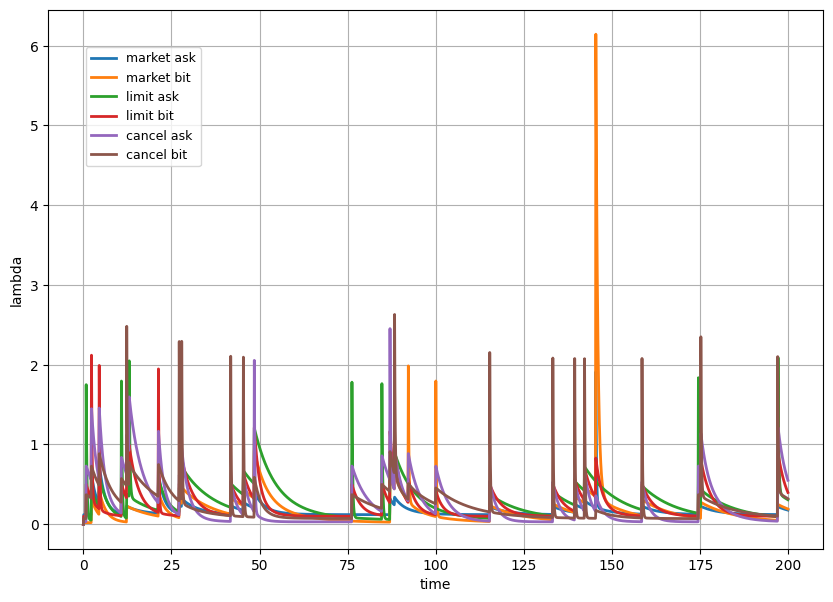

[2.205492463402323, 'CMB0', 1]
[2.205492463402323, 'SH', 1]
[4.438116481899187, 'CMB0', 3]
[4.438116481899187, 'SH', 4]
[10.734440402549858, 'CMA0', 1]
[10.734440402549858, 'SH', 3]
[12.224524816271146, 'LMB1', 1]
[12.224524816271146, 'SH', 4]
[12.97676268169258, 'CMA0', 2]
[12.97676268169258, 'SH', 2]
[21.2256315882396, 'CMB0', 2]
[21.2256315882396, 'SH', 4]
[27.1700296951737, 'LMB1', 1]
[27.1700296951737, 'SH', 5]
[27.849796645702757, 'LMB1', 1]
[27.849796645702757, 'SH', 6]
[41.764140845587235, 'LMB1', 1]
[41.764140845587235, 'SH', 7]
[45.350716431950254, 'LMB1', 2]
[45.350716431950254, 'SH', 9]
[48.43166434689537, 'LMA1', 1]
[48.43166434689537, 'SH', 10]
[76.11553340960367, 'CMA0', 3]
[76.11553340960367, 'SH', 7]
[84.62592555688441, 'CMA0', 5]
[84.62592555688441, 'SH', 2]
[86.98933224584003, 'LMA1', 24]
[86.98933224584003, 'SH', 26]
[88.26078653980433, 'LMB1', 6]
[88.26078653980433, 'SH', 32]
[92.12143269912693, 'MKB', 1]
[92.12143269912693, 'EXE', 1]
[92.12143269912693, '-h']
[99.

In [21]:
if __name__ == '__main__':
    names = ['market ask', 'market bit', 'limit ask', 'limit bit', 'cancel ask', 'cancel bit']
    mu = np.array([0.12, 0.02, 0.05, 0.10, 0.03, 0.07])
    alpha = np.array([
    [1.7, 5.8, 0, 0.5, 0.2, 0.1],
    [0, 1.7, 0, 0.3, 0.6, 0.2],
    [0, 0, 1.7, 0.4, 0.7, 0.3],
    [0.5, 0.3, 0.4, 1.8, 0.9, 0.4],
    [0.2, 0.6, 0.7, 0.9, 1.9, 0.5],
    [0.1, 0.2, 0.3, 0.4, 0.5, 2.0]
])
    beta = np.array([
    [5.8, 1.8, 0, 0.6, 0.4, 0.2],
    [0, 6.0, 0, 0.5, 0.3, 0.1],
    [0, 0, 5.0, 0.4, 0.2, 0.1],
    [0.6, 0.5, 0.4, 5.9, 0.7, 0.3],
    [0.4, 0.3, 0.2, 0.7, 6.1, 0.5],
    [0.2, 0.1, 0.1, 0.3, 0.5, 6.2]
])

    T = 200.0
    hp = MHawkes(names, mu, alpha, beta, T)
    #hp.set_seed(1234)
    hp.gen()
    #hp.print_tm()
    hp.plot_lmd(0.1, 'Hawkes')
    hp.make_events()
    hp.print_events()

In [22]:
def generate_hawkes_parameters(N, base_intensity=0.1, alpha_scale=1.0, beta_scale=1.0):
    # Determine the sizes of mu, alpha, and beta matrices
    mu_size = (1, N*4 + 2)
    alpha_size = (N*4 + 2, N*4 + 2)
    beta_size = (N*4 + 2, N*4 + 2)

    # Generate mu as a random value scaled by base_intensity
    mu = base_intensity * np.random.rand(*mu_size)

    # Generate alpha as a random matrix with diagonal dominance and non-negative off-diagonal elements
    alpha = alpha_scale * np.random.rand(*alpha_size)
    np.fill_diagonal(alpha, np.random.rand(alpha_size[0]))  # Ensure diagonal dominance

    # Generate beta as a random matrix with diagonal dominance and non-negative off-diagonal elements
    beta = beta_scale * np.random.rand(*beta_size)
    np.fill_diagonal(beta, np.random.rand(beta_size[0]))  # Ensure diagonal dominance

    return mu, alpha, beta

# Example usage:
if __name__ == '__main__':
    N = 2  # Replace with your desired value of N
    mu, alpha, beta = generate_hawkes_parameters(N)
    print("mu:")
    print(mu)
    print("alpha:")
    print(alpha)
    print("beta:")
    print(beta)


mu:
[[0.04782901 0.07391323 0.04874551 0.0868901  0.07322112 0.09041258
  0.03073537 0.03285589 0.00685519 0.0267847 ]]
alpha:
[[0.77710323 0.63572216 0.59384162 0.90192315 0.28353876 0.26282502
  0.69272319 0.87815939 0.60376752 0.98482299]
 [0.51506033 0.83059625 0.52223013 0.42847983 0.46072936 0.20195084
  0.81025253 0.10500401 0.44770986 0.04718507]
 [0.18545147 0.20598294 0.65504483 0.93165924 0.64134293 0.85368285
  0.77522793 0.95340814 0.87112338 0.85208697]
 [0.15301654 0.11810577 0.6326125  0.1494037  0.61545771 0.98020767
  0.18142141 0.02667512 0.09165181 0.13850221]
 [0.1293653  0.32291591 0.57938131 0.55039329 0.02805662 0.72912849
  0.51758339 0.2073997  0.0902485  0.22923286]
 [0.43195565 0.40660944 0.97847336 0.25708745 0.91665276 0.53676267
  0.0650526  0.8312013  0.23241735 0.29784324]
 [0.96716724 0.15565838 0.95490539 0.19181707 0.04168724 0.97155356
  0.10999717 0.43307071 0.44942807 0.03239191]
 [0.77266146 0.7871509  0.91335119 0.05053419 0.27509075 0.34331555


IndexError: list index out of range

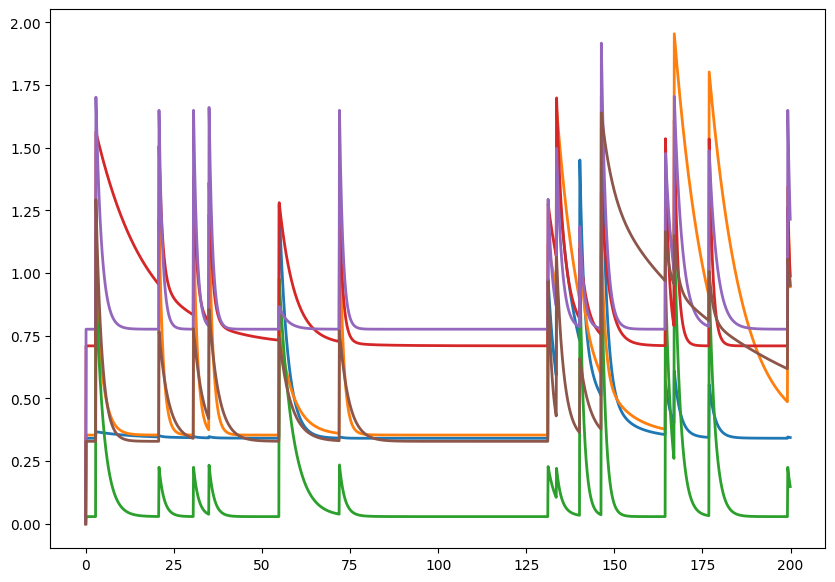

In [27]:
def generate_hawkes_parameters(N):
    # Generate mu as a random vector of size 1x(4N+2)
    mu = np.random.rand(4*N + 2)

    # Generate alpha as a random matrix of size (4N+2)x(4N+2)
    alpha = np.random.rand(4*N + 2, 4*N + 2)
    np.fill_diagonal(alpha, np.random.rand(4*N + 2))  # Ensure diagonal dominance

    # Generate beta as a random matrix of size (4N+2)x(4N+2)
    beta = np.random.rand(4*N + 2, 4*N + 2)
    np.fill_diagonal(beta, np.random.rand(4*N + 2))  # Ensure diagonal dominance

    return mu, alpha, beta

# Example usage:
if __name__ == '__main__':
    names = ['market ask', 'market bit', 'limit ask', 'limit bit', 'cancel ask', 'cancel bit']
    N = 2  # Level
    mu, alpha, beta = generate_hawkes_parameters(N)

    T = 200.0
    hp = MHawkes(names, mu, alpha, beta, T)
    hp.gen()
    hp.plot_lmd(0.1, 'Hawkes')
    hp.make_events()
    hp.print_events()


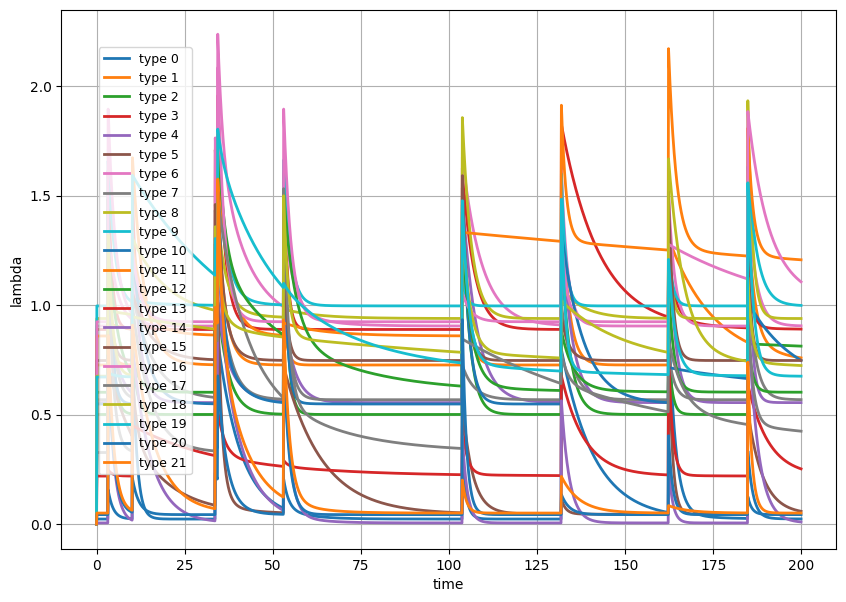

[3.2119302205992244, 'LMA4', 0.48534126163836633]
[3.2119302205992244, 'SH', 0.48534126163836633]
[10.114447955553395, 'CMA3', 0.3627661899329627]
[10.114447955553395, 'SH', 0.1225750717054036]
[33.67752511169224, 'LMB2', 0.6228755861637754]
[33.67752511169224, 'SH', 0.745450657869179]
[34.39034238459853, 'LMA5', 0.6981012973768699]
[34.39034238459853, 'SH', 1.4435519552460487]
[53.071934519115274, 'LMA4', 0.23097816225968237]
[53.071934519115274, 'SH', 1.6745301175057312]
[103.7725978441601, 'LMB4', 0.7821070171856719]
[103.7725978441601, 'SH', 2.456637134691403]
[131.83510907402885, 'CMB3', 0.7980161532378056]
[131.83510907402885, 'SH', 3.2546532879292087]
[162.22747818845897, 'LMA1', 0.11451437663961339]
[162.22747818845897, 'SH', 3.369167664568822]
[184.7649571453324, 'CMA0', 0.22275708817665918]
[184.7649571453324, 'SH', 3.146410576392163]
0
0
0
0
0


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def generate_hawkes_parameters(N):
    # Generate mu as a random vector of size 1x(4N+2)
    mu = np.random.rand(4*N + 2)

    # Generate alpha as a random matrix of size (4N+2)x(4N+2)
    alpha = np.random.rand(4*N + 2, 4*N + 2)
    np.fill_diagonal(alpha, np.random.rand(4*N + 2))  # Ensure diagonal dominance

    # Generate beta as a random matrix of size (4N+2)x(4N+2)
    beta = np.random.rand(4*N + 2, 4*N + 2)
    np.fill_diagonal(beta, np.random.rand(4*N + 2))  # Ensure diagonal dominance

    return mu, alpha, beta

# Class definition for Mutual-Exciting Hawkes process
class MHawkes(object):
    def __init__(self, names, mu, alpha, beta, T):
        # parameters
        self.names = names # event types
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.M = len(self.mu) # number of event types
        self.x = [0] * (self.M//4) # board

        self.ur = np.random.RandomState()

        # sequence of jump times
        self.tm = [] # list of marked jumps with shares [t, m, sh]

        self.ones = np.ones((self.M), dtype=float)

        # Placeholder for some class Zetad
        self.zetad = np.random.RandomState()

        self.events = []

    def set_seed(self, seed):
        np.random.seed(seed)

    def gen(self): # generate marked point process; i.e. a list of (time, event_type, shares)
        t = 0.0
        eta = np.zeros((self.M, self.M), dtype=float)   # (4.4)
        lmd = self.mu # vector of last lambda values    # (4.7)
        while True:
            lmd = self.mu + np.matmul(self.ones, eta) # (4.7)
            sumLmd = lmd.sum()
            s = np.random.exponential(sumLmd) # time interval until next 'something happens
            t += s
            if t > self.T:
                break
            d = self.ur.rand()
            l = sumLmd * d
            m = -1  # then, what is 'something'?
            psl = 0.0
            while np.any(psl < l):
                m += 1
                if m >= self.M:
                    break
                psl += lmd[m]
            # we figured out what 'something' was. It's m.
            eta *= np.exp(- self.beta * s) # Case 1; proceed time immediately before 'm' happens; (4.11)
            # and then, update 'eta' just after 'm' happens
            eta[m] += self.alpha[m] # Case 2; (4.12)
            sh = self.zetad.rand()   # get number of shares
            self.tm.append([t, m, sh])

    def lmbd(self, dt):
        steps = int(self.T / dt)
        lmd_t = np.zeros((steps, self.M), dtype=float) # [time, type]-matrix; will be transported at the return; (4.3)
        eta = np.zeros((self.M, self.M), dtype = float) # (4.4)
        k = 0 # time in step
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            k0 = int(t / dt)
            if k0 * dt < t: k0 += 1
            # assume t <= k0 * dt
            k1 = k0
            if k1 >= steps: k1 -= 1
            while k < k1:
                k += 1
                eta *= np.exp(- self.beta * dt) # Caes 1: (4.9)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
            if k == k0:
                eta[m] += self.alpha[m] # Case 2: (4.10)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        # all jumps have been processed
        while k < steps - 1:
            k += 1
            eta *= np.exp(- self.beta * dt) # Case 1: (4.9)
            lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        return np.transpose(lmd_t)

    def plot_lmd(self, dt, outf=''):
        f = plt.figure()
        f.set_size_inches(10,7)
        steps = int(self.T / dt)
        ts = dt * np.arange(steps)
        lmd = self.lmbd(dt) # [type, time]-matrix
        for m in range(self.M):
            plt.plot(ts, lmd[m], linewidth=2, label=self.names[m])
        plt.xlabel('time')
        plt.ylabel('lambda')
        plt.grid()
        plt.legend(loc='upper left', borderaxespad=3.0, fontsize=9)
        plt.show()
        if outf != '':
            f.savefig(outf + '.pdf', bbox_inches='tight')

    def make_events(self):  # make the event list self.events according to self.tm.
        evs = []  # list of events

        cur_sh = 0
        for tm in self.tm:
            t = tm[0]  # event time
            m = tm[1]  # event type
            s = tm[2]  # event shares
            if m == 0:  # market ask
                if s > cur_sh:
                    s = cur_sh
                if s > 0:
                    evs.append([t, 'MKA', s])
                    evs.append([t, 'EXE', s])
                    cur_sh -= s
                    evs.append([t, '-h'])
            elif m == 1:  # market bid
                if s > 0:
                    evs.append([t, 'MKB', s])
                    evs.append([t, 'EXE', s])
                    cur_sh += s
                    evs.append([t, '-h'])
            elif m % 4 == 0:  # limit ask
                evs.append([t, f'LMA{m//4}', s])
                cur_sh += s
                evs.append([t, 'SH', cur_sh])
            elif m % 4 == 1:  # limit bid
                evs.append([t, f'LMB{m//4}', s])
                cur_sh += s
                evs.append([t, 'SH', cur_sh])
            elif m % 4 == 2:  # cancel market ask
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, f'CMA{m//4}', s])
                    cur_sh -= s
                    evs.append([t, 'SH', cur_sh])
            elif m % 4 == 3:  # cancel bid
                if s > 0:
                    evs.append([t, f'CMB{m//4}', s])
                    cur_sh += s
                    evs.append([t, 'SH', cur_sh])

        self.events = evs

    def print_tm(self):
        print(self.t)
        for tm in self.tm:
            print(tm)

    def print_events(self):
        for ev in self.events:
            print(ev)

    def print_board(self):
        for i in self.x:
            print(self.x[i])

# Main function
if __name__ == '__main__':
    N = 5  # Level
    names = [f'type {i}' for i in range(4*N + 2)]
    mu, alpha, beta = generate_hawkes_parameters(N)

    T = 200.0
    hp = MHawkes(names, mu, alpha, beta, T)
    hp.gen()
    hp.plot_lmd(0.1, 'Hawkes')
    hp.make_events()
    hp.print_events()
    hp.print_board()
